## Imports

In [13]:
import sys
sys.path.append('../')

In [14]:
from munch import Munch
from PIL import Image
import torch
import numpy as np
import cv2

In [15]:
from core.data_loader import get_test_transform
from core.solver import Solver
from core.wing import FaceAligner
from core.utils import denormalize

In [16]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Objective

* Integrate face alignment into `predict` flow

## Model args

In [17]:
args = Munch({
    'img_size': 256,
    'style_dim': 64,
    'w_hpf': 1.0,
    'latent_dim': 16,
    'num_domains': 2,
    'wing_path': '../expr/checkpoints/wing.ckpt',
    'lm_path': '../expr/checkpoints/celeba_lm_mean.npz',
    'resume_iter': 100000,
    'checkpoint_dir': '../expr/checkpoints/celeba_hq',
    'mode': 'sample'
})

## Examine `align` in original repository

In [18]:
aligner = FaceAligner(args.wing_path, args.lm_path, args.img_size)

In [7]:
source = Image.open('../assets/representative/celeba_hq/src/female/039913.jpg')

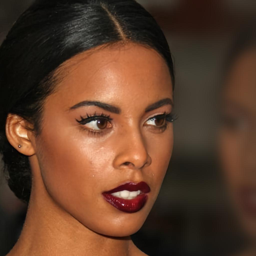

In [8]:
source.resize((256,256))

In [9]:
transform = get_test_transform(256)

In [10]:
transformed_source = transform(source)

In [11]:
transformed_source = transformed_source.unsqueeze(0);

In [12]:
transformed_source.shape

torch.Size([1, 3, 256, 256])

### First Run

In [13]:
%%time
aligned_source = aligner.align(transformed_source)

/home/kianboonkoh/miniconda3/envs/stargan-v2/lib/python3.6/site-packages/torch/nn/functional.py:3063: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


CPU times: user 489 ms, sys: 189 ms, total: 679 ms
Wall time: 588 ms


In [14]:
output = aligned_source.squeeze()
output = denormalize(output)
output = output.mul(255).add_(0.5).clamp_(0, 255).permute(1, 2, 0)
output = output.to('cpu', torch.uint8).numpy()

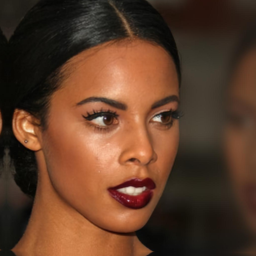

In [15]:
Image.fromarray(output)

### Custom Image

In [16]:
source = Image.open('../assets/representative/custom/male/custom_male.jpg')

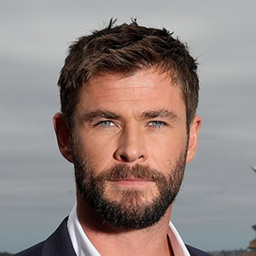

In [17]:
source.resize((256,256))

In [18]:
transform = get_test_transform(256)
transformed_source = transform(source)
transformed_source = transformed_source.unsqueeze(0);

In [19]:
%%time
aligned_source = aligner.align(transformed_source)

CPU times: user 219 ms, sys: 2.67 ms, total: 222 ms
Wall time: 95 ms


/home/kianboonkoh/miniconda3/envs/stargan-v2/lib/python3.6/site-packages/torch/nn/functional.py:3063: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


In [20]:
output = aligned_source.squeeze()
output = denormalize(output)
output = output.mul(255).add_(0.5).clamp_(0, 255).permute(1, 2, 0)
output = output.to('cpu', torch.uint8).numpy()

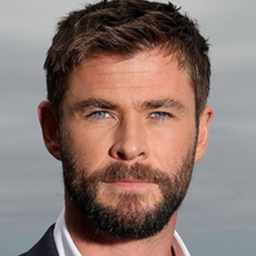

In [21]:
Image.fromarray(output)

## Integrate with `predict` flow

In [6]:
aligner = FaceAligner(args.wing_path, args.lm_path, args.img_size)

In [7]:
source = Image.open('../assets/representative/celeba_hq/src/female/039913.jpg')
ref = Image.open('../assets/representative/celeba_hq/ref/female/015248.jpg')

In [8]:
solver = Solver(args)

Number of parameters of generator: 43467395
Number of parameters of mapping_network: 2438272
Number of parameters of style_encoder: 20916928
Number of parameters of discriminator: 20852290
Number of parameters of fan: 6333603
Initializing generator...
Initializing mapping_network...
Initializing style_encoder...
Initializing discriminator...


In [9]:
solver._load_checkpoint(args.resume_iter)

Loading checkpoint from ../expr/checkpoints/celeba_hq/100000_nets_ema.ckpt...


### Without alignment

/home/kianboonkoh/miniconda3/envs/stargan-v2/lib/python3.6/site-packages/torch/nn/functional.py:3063: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


CPU times: user 4.01 s, sys: 119 ms, total: 4.13 s
Wall time: 511 ms


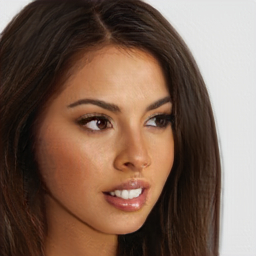

In [10]:
%time solver.predict(source, ref, 'female')

### With alignment

/home/kianboonkoh/miniconda3/envs/stargan-v2/lib/python3.6/site-packages/torch/nn/functional.py:3063: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


CPU times: user 3.16 s, sys: 83.7 ms, total: 3.24 s
Wall time: 190 ms


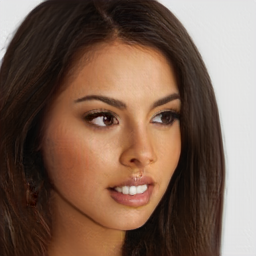

In [11]:
%%time
solver.predict(source, ref, 'female', face_aligner=aligner)

### Another example

In [16]:
source = Image.open('../assets/representative/custom/female/custom_female.jpg')
ref = Image.open('../assets/representative/custom/male/custom_male.jpg')

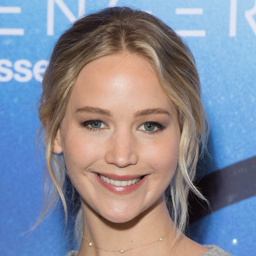

In [17]:
source.resize((256,256))

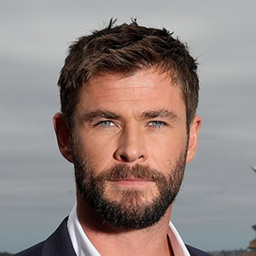

In [18]:
ref.resize((256,256))

### Without alignment

CPU times: user 1.63 s, sys: 70.4 ms, total: 1.7 s
Wall time: 102 ms


/home/kianboonkoh/miniconda3/envs/stargan-v2/lib/python3.6/site-packages/torch/nn/functional.py:3063: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


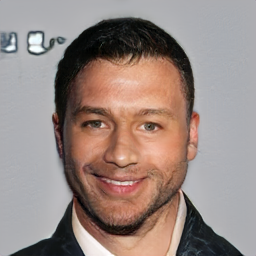

In [19]:
%time solver.predict(source, ref, 'male')

### With alignment

/home/kianboonkoh/miniconda3/envs/stargan-v2/lib/python3.6/site-packages/torch/nn/functional.py:3063: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


CPU times: user 3.73 s, sys: 83.8 ms, total: 3.81 s
Wall time: 222 ms


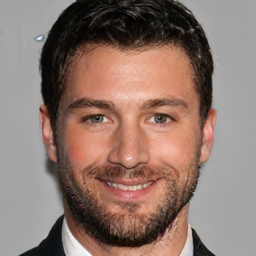

In [21]:
%time solver.predict(source, ref, 'male', face_aligner=aligner)

## Wrapped as `FaceAligner` in flask_app/model/declarations.py

In [5]:
from flask_app.model import declarations

In [7]:
model = declarations.FaceAligner()

In [8]:
model.init_model(args)

In [9]:
source = Image.open('../assets/representative/custom/male/custom_male.jpg')

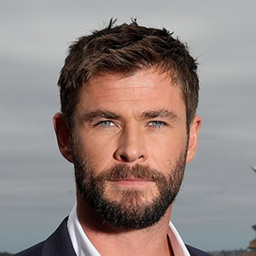

In [10]:
source.resize((256,256))

CPU times: user 1.28 s, sys: 16.7 ms, total: 1.29 s
Wall time: 73.8 ms


/home/kianboonkoh/miniconda3/envs/stargan-v2/lib/python3.6/site-packages/torch/nn/functional.py:3063: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


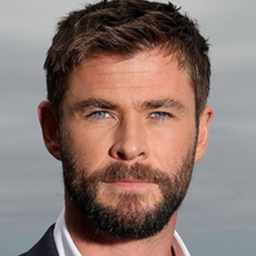

In [12]:
%%time
model.predict({'img': source})

## Conclusion

* Alignment takes up about additional 100ms
* Approx. doubles time taken for prediction
* if not required, face alignment not required